<a href="https://colab.research.google.com/github/AlyssaAmod/UNN_BraTS23/blob/main/Augmentations_Efficient_AAupdated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install synapseclient

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.3/218.3 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: keyring
    Found existing installation: keyring 23.5.0
    Uninstalling keyring-23.5.0:
      Successfully uninstalled keyring-23.5.0


In [2]:
import synapseclient
syn = synapseclient.Synapse()
syn.login(email='pearlyjoubert2@gmail.com', password='SPARK_BRATS_2023')
SSA = syn.get("syn51692615")
GLI = syn.get("syn51514132")
# creating file path
SSA_path = SSA.path
GLI_path = GLI.path


specific_string = "BraTS-"

[WARNING] Logging into Synapse via passwords will be deprecated by early 2024. This message will disappear if you use a Synapse Personal Access Token to login.


Welcome, pearlyjoubert2@gmail.com!



INFO:synapseclient_default:Welcome, pearlyjoubert2@gmail.com!



In [44]:
import zipfile
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install torchio
import torchio as tio

from torchio.transforms import RandomFlip
path_to_SSA = SSA_path
path_to_GLI = GLI_path
SSA_dir = "/content/sample_data/SSA_data"
if not os.path.exists(SSA_dir):
    os.mkdir(SSA_dir)
GLI_dir = "/content/sample_data/GLI_data"
if not os.path.exists(GLI_dir):
    os.mkdir(GLI_dir)

with zipfile.ZipFile(path_to_SSA, 'r') as zip_ref:
    zip_ref.extractall(SSA_dir)

with zipfile.ZipFile(path_to_GLI, 'r') as zip_ref:
    zip_ref.extractall(GLI_dir)

In [69]:
def transforms():
    #Cropping patch
    patch = tio.CropOrPad(target_shape=128, mask_name='labels',labels=[1,2,3], padding_mode='edge')

    #Random flips along a single axes
    flipR = tio.Compose([
        tio.RandomFlip(axes=0, p=0.3),
        tio.RandomFlip(axes=1, p=0.3),
        tio.RandomFlip(axes=2, p=0.3)])

    #fakeSSA resample approaches
    resampleR = tio.Compose([
                tio.Resample((1.2, 1.2, 6), scalars_only=True),
                tio.Resample(1)])

    anisoR = tio.Compose([
                tio.RandomAnisotropy(axes=(1, 2), downsampling=(1.2), scalars_only=True),
                tio.RandomAnisotropy(axes=0, downsampling=(6), scalars_only=True)])

    #Simulating scanner artefacts
    blurR = tio.RandomBlur(std=(0.5, 1.5))
    noiseR = tio.RandomNoise(mean=0, std=(0, 0.33))
    motionR = tio.RandomMotion(num_transforms=3, image_interpolation='nearest')
    biasfR = tio.RandomBiasField(coefficients=1)
    ghostR = tio.RandomGhosting(intensity=1.5)

    #full training implementations
    train = tio.Compose([
        tio.CropOrPad(target_shape=128, mask_name='labels',labels=[1,2,3], padding_mode='edge'),
        tio.OneOf([
            tio.Compose([
                tio.RandomFlip(axes=0, p=0.3),
                tio.RandomFlip(axes=1, p=0.3),
                tio.RandomFlip(axes=2, p=0.3)]),
            tio.RandomAffine(degrees=15,p=0.3)
        ], p=0.8),
        tio.EnsureShapeMultiple(2**7, method='pad')])

    fakeSSA_resamp = tio.Compose([
        tio.CropOrPad(target_shape=128, mask_name='labels',labels=[1,2,3], padding_mode='edge'),
        tio.OneOf([
            tio.Compose([
                tio.RandomFlip(axes=0, p=0.3),
                tio.RandomFlip(axes=1, p=0.3),
                tio.RandomFlip(axes=2, p=0.3)]),
            tio.RandomAffine(degrees=15,p=0.3)
        ], p=0.8),
        tio.EnsureShapeMultiple(2**7, method='pad'),
        tio.OneOf({
            tio.Compose([
                tio.Resample((1.2, 1.2, 6), scalars_only=True),
                tio.Resample(1)
            ]):0.50,
            tio.Compose([
                tio.RandomAnisotropy(axes=(1, 2), downsampling=(1.2), scalars_only=True),
                tio.RandomAnisotropy(axes=0, downsampling=(6), scalars_only=True)
            ]):0.50,},p=0.50)
        ])

    fakeSSA_augs = tio.Compose([
        tio.CropOrPad(target_shape=128, mask_name='labels',labels=[1,2,3], padding_mode='edge'),
        tio.OneOf([
            tio.Compose([
                tio.RandomFlip(axes=0, p=0.3),
                tio.RandomFlip(axes=1, p=0.3),
                tio.RandomFlip(axes=2, p=0.3)]),
            tio.RandomAffine(degrees=15,p=0.3)
        ], p=0.8),
        tio.EnsureShapeMultiple(2**7, method='pad'),
        tio.Compose([
            tio.OneOf({
                tio.RandomBlur(std=(0.5, 1.5)) : 0.3,
                tio.RandomNoise(mean=3, std=(0, 0.33)) : 0.7
            },p=0.50),
            tio.OneOf({
                tio.RandomMotion(num_transforms=3, image_interpolation='nearest') : 0.5,
                tio.RandomBiasField(coefficients=1) : 0.2,
                tio.RandomGhosting(intensity=1.5) : 0.3
            }, p=0.50)])
        ])
    # creating a dictionary for the different augmentations
    Augs = {1: flipR, 2: resampleR, 3: anisoR, 4: blurR, 5: noiseR, 6: motionR, 7: biasfR, 8: ghostR, 9: patch, 10: train, 11: fakeSSA_resamp, 12: fakeSSA_augs}

    return Augs


In [15]:
def print_files(x, Aug_index, patient_index):
    # Get a list of all the folders in the specified directory path
    folders = [folder for folder in os.listdir(x) if os.path.isdir(os.path.join(x, folder))]

    # Randomly select a folder from the list
    selected_folder = random.choice(folders)

    print(selected_folder)
    # Get the complete path of the selected folder
    selected_folder_path = os.path.join(x, selected_folder)

    # Get a list of all the files inside the selected folder
    files = os.listdir(selected_folder_path)
    print(files)
    #random_number = random.randint(0, 61)
    #use_file = random.choice(files)

    # list of patients
    patient_num = ["BraTS-GLI-01442-000", "BraTS-GLI-00090-000", "BraTS-GLI-00445-000", "BraTS-GLI-00642-000", "BraTS-GLI-00828-000"]

    #######################
    ##### change the index to choose a patient
    use_file = patient_num[patient_index] # change the value to indicate which patient you are interested in
    ######################

    selected_subfolder_path = os.path.join(x, selected_folder, use_file)
    dir_list = os.listdir(selected_subfolder_path)
    SSA_data = "/content/sample_data/GLI_data"
    if not os.path.exists(SSA_data):
      os.mkdir(SSA_data)

    labels_SSA = []
    SSA_loop = []
    before = [] # initiate list of images
    for item in dir_list:
      print(item)
      item_path = os.path.join(selected_subfolder_path, item)
      print(item_path)
      if os.path.isfile(item_path):
        GLI_image = tio.ScalarImage(item_path) #converts to 4D tensor

        base_name = os.path.basename(item_path)
        base_name_without_extension = base_name[:-7]
        parts = base_name_without_extension.split("-")
        other = base_name_without_extension.split("-")
        mod_type = parts[-1]
        Patient = other[-3]
        print(Patient)

        ## keep track of images without Augmentations
        img = nib.load(item_path)
        data_before = np.array(img.dataobj) # this line is so that we can keep track of the images without Augs
        image_before = data_before[ :, :, 75]
        plt.imshow(image_before, cmap='gray')
        plt.axis('off')
        plt.savefig(os.path.join(SSA_data + "-" + Patient + "-" +  mod_type + '.png'))

        before.append(image_before)
        # different augmentations now defined in previous cell
        Augs = transforms()
        #change the index depending on the Aug used
        ########################################################
        # Aug_index = 4
        #########################################################
        transform = Augs[Aug_index] # choose the axis to flip (x,y,z) used p=0.3 initially

        transformed_image = transform(GLI_image)

        transformed_new = np.squeeze(transformed_image)
        data = np.array(transformed_new)
        print(f"transformed shapes {transformed_image.shape}, squeezed shape {transformed_new.shape}, as np.array is {data.shape}")


        #nifti_data = nifti_file.get_fdata()
        image = data[ :, :, 75]
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.savefig(os.path.join(SSA_data + "-" + Patient + "-" +  mod_type + '.png'))
        #plt.show()

        SSA_loop.append(image)

        labels_SSA.append(mod_type)
        print(labels_SSA)
        list_paths = ["/content/sample_data/RandomFlip_GLI/",
                      "/content/sample_data/Resample_GLI/",
                      "/content/sample_data/AnisoR_GLI/",
                      "/content/sample_data/BlurR_GLI/",
                      "/content/sample_data/NoiseR_GLI/",
                      "/content/sample_data/MotionR_GLI/",
                      "/content/sample_data/BiasFieldR_GLI/",
                      "/content/sample_data/patch_GLI/",
                      "/content/sample_data/train_GLI/",
                      "/content/sample_data/fakeSSA_resamp/",
                      "/content/sample_data/fakeSSA_augs/"]
        # remember to change the index depending on the Aug you choose
        subplot_path = list_paths[Aug_index - 1]
        if not os.path.exists(subplot_path):
          os.mkdir(subplot_path)
            #label_mod = ["t2w", "t2f"]
        if len(labels_SSA) > 4:
          mod_t2w = labels_SSA.index("t2w")
          mod_t2f = labels_SSA.index("t2f")

          # Display the images WITH Augmentations
          fig, ax = plt.subplots(1,2)
          ax[0].imshow(SSA_loop[mod_t2w], cmap = "gray")
          ax[1].imshow(SSA_loop[mod_t2f], cmap = "gray")
          ax[0].set_title("tw2")
          ax[1].set_title("t2f")
          plt.suptitle("With Augmentation")
          plt.savefig(os.path.join(subplot_path + "GLI" + "-" +  Patient +  '.png'), bbox_inches='tight')
          plt.show()

          # Display the imageS WITHOUT Augmentations
          fig, ax = plt.subplots(1,2)
          ax[0].imshow(before[mod_t2w], cmap = "gray")
          ax[1].imshow(before[mod_t2f], cmap = "gray")
          ax[0].set_title("tw2")
          ax[1].set_title("t2f")
          plt.suptitle("No Augmentation")
          plt.savefig(os.path.join(subplot_path + "GLI" + "-" +  Patient +  '.png'), bbox_inches='tight')
          plt.show()


ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData
['BraTS-GLI-01123-000', 'BraTS-GLI-00105-000', 'BraTS-GLI-00839-000', 'BraTS-GLI-01419-000', 'BraTS-GLI-00493-000', 'BraTS-GLI-00694-001', 'BraTS-GLI-00253-000', 'BraTS-GLI-01300-000', 'BraTS-GLI-00575-000', 'BraTS-GLI-01283-000', 'BraTS-GLI-00024-000', 'BraTS-GLI-00206-000', 'BraTS-GLI-00260-000', 'BraTS-GLI-00160-000', 'BraTS-GLI-00747-000', 'BraTS-GLI-00031-001', 'BraTS-GLI-01478-000', 'BraTS-GLI-01163-000', 'BraTS-GLI-00551-000', 'BraTS-GLI-01000-000', 'BraTS-GLI-00514-000', 'BraTS-GLI-00389-000', 'BraTS-GLI-00286-000', 'BraTS-GLI-01260-000', 'BraTS-GLI-01022-000', 'BraTS-GLI-00329-000', 'BraTS-GLI-01453-000', 'BraTS-GLI-00051-000', 'BraTS-GLI-01532-000', 'BraTS-GLI-01412-000', 'BraTS-GLI-01160-001', 'BraTS-GLI-00599-000', 'BraTS-GLI-00578-000', 'BraTS-GLI-01069-000', 'BraTS-GLI-01050-000', 'BraTS-GLI-00370-000', 'BraTS-GLI-00663-000', 'BraTS-GLI-01008-000', 'BraTS-GLI-00304-000', 'BraTS-GLI-00212-000', 'BraTS-GLI-00483-001', 'BraTS-

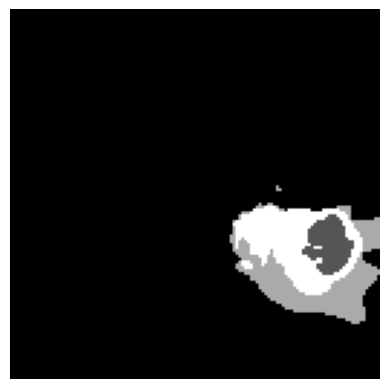

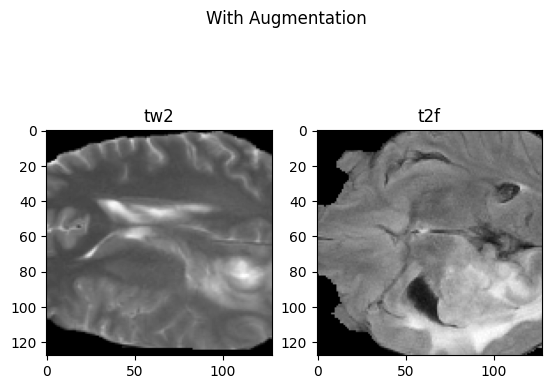

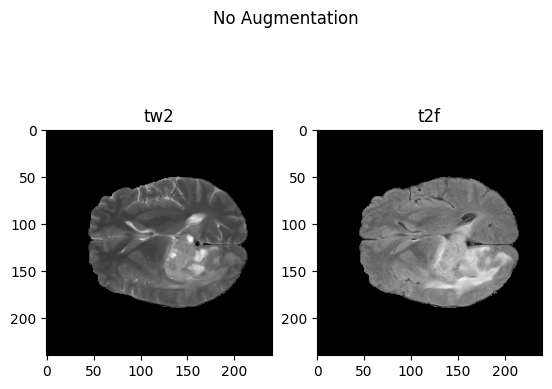

ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData
['BraTS-GLI-01123-000', 'BraTS-GLI-00105-000', 'BraTS-GLI-00839-000', 'BraTS-GLI-01419-000', 'BraTS-GLI-00493-000', 'BraTS-GLI-00694-001', 'BraTS-GLI-00253-000', 'BraTS-GLI-01300-000', 'BraTS-GLI-00575-000', 'BraTS-GLI-01283-000', 'BraTS-GLI-00024-000', 'BraTS-GLI-00206-000', 'BraTS-GLI-00260-000', 'BraTS-GLI-00160-000', 'BraTS-GLI-00747-000', 'BraTS-GLI-00031-001', 'BraTS-GLI-01478-000', 'BraTS-GLI-01163-000', 'BraTS-GLI-00551-000', 'BraTS-GLI-01000-000', 'BraTS-GLI-00514-000', 'BraTS-GLI-00389-000', 'BraTS-GLI-00286-000', 'BraTS-GLI-01260-000', 'BraTS-GLI-01022-000', 'BraTS-GLI-00329-000', 'BraTS-GLI-01453-000', 'BraTS-GLI-00051-000', 'BraTS-GLI-01532-000', 'BraTS-GLI-01412-000', 'BraTS-GLI-01160-001', 'BraTS-GLI-00599-000', 'BraTS-GLI-00578-000', 'BraTS-GLI-01069-000', 'BraTS-GLI-01050-000', 'BraTS-GLI-00370-000', 'BraTS-GLI-00663-000', 'BraTS-GLI-01008-000', 'BraTS-GLI-00304-000', 'BraTS-GLI-00212-000', 'BraTS-GLI-00483-001', 'BraTS-

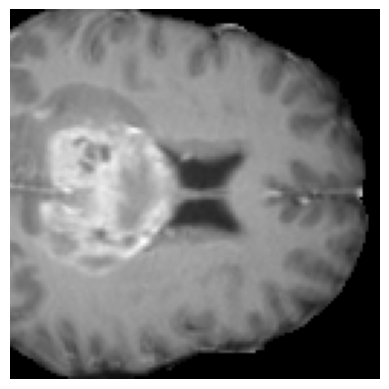

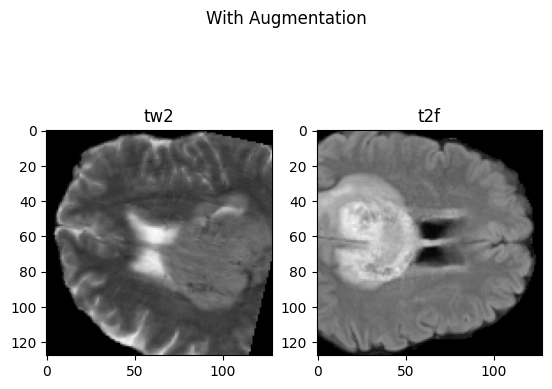

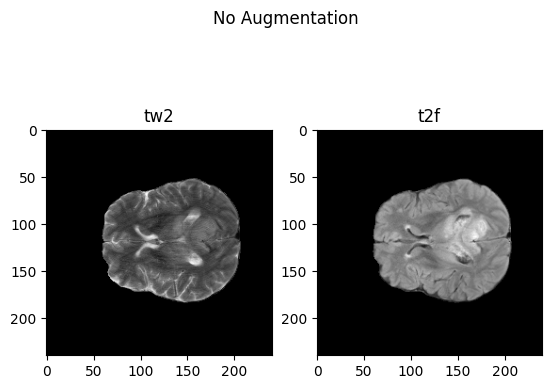

In [17]:
# enter a numerical value depending on the patient you are interested in:
#############################################
#Choose patient
#0 - "BraTS-GLI-01442-000"
#1 - "BraTS-GLI-00090-000"
#2 - "BraTS-GLI-00445-000"
#3 - "BraTS-GLI-00642-000"
#4 - "BraTS-GLI-00642-000"

# choose augmentation
#1: flipR
#2: resampleR
#3: anisoR
#4: blurR
#5: noiseR
#6: motionR
#7: biasfR
#8: ghostR
# 9: patch
# 10: train
# 11: fakeSSA_resamp
# 12: fakeSSA_augs
###############################################
# print_files (dir, Aug_index, Patient_index)
# NB !! Rememebr to change the Aug_index depending on the Aug you choose.

print_files(GLI_dir, 10, 2)
print_files(GLI_dir, 10, 4)



In [ ]:


# Load the image
image = tio.ScalarImage('/content/sample_data/GLI_data/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2w.nii.gz')

# Apply RandomFlip transformation
transform = tio.RandomFlip(axes=(0, 1))
transformed_image = transform(image)
new = np.squeeze(transformed_image)
print(new.shape)

# Print the transformed image
#print(transformed_image.shape)
#convert = np.array(transformed_image)
#print(convert)




(240, 240, 155)


## AA adapting PJ code so uses torchio subject like data_class --> changed var names to make sure nothing clashes when running

In [47]:
print(GLI_dir)
data_dir = os.path.join(GLI_dir, "ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData")
print(data_dir)

/content/sample_data/GLI_data
/content/sample_data/GLI_data/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData


In [67]:
def plot_augs(data_dir, aug_idx):
    # list of patients
    # patient_num = ["BraTS-GLI-01442-000", "BraTS-GLI-00090-000", "BraTS-GLI-00445-000", "BraTS-GLI-00642-000", "BraTS-GLI-00828-000"]
    SSA_data = "/content/sample_data/augments"
    if not os.path.exists(SSA_data):
      os.mkdir(SSA_data)
    subject_dirs = sorted([os.path.join(data_dir, subject_dir) for subject_dir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subject_dir)) and subject_dir.startswith(specific_string)])

    print("Total folders: ", len(subject_dirs))
    subj_folder = subject_dirs[random.randrange(0, len(subject_dirs))]
    print(f"Working with subject: {subj_folder}")

    # Iterate through the subject folders
    subject_id = os.path.basename(subj_folder)
    # Create a list to hold the subject's images and labels
    images = []
    labels = []
    img_paths = []
    img_modality = []
    # Load each scan modality and segmentation
    for modality in ['t1n', 't1c', 't2w', 't2f']:
        image_path = os.path.join(subj_folder, f'{subject_id}-{modality}.nii.gz')
        img_paths.append(image_path)
        image = tio.ScalarImage(image_path)
        images.append(image)

    loaded_modalities = [nib.load(path) for path in img_paths]
    t1n, t1c, t2w, t2f = loaded_modalities
    img_modality.extend([t1n, t1c, t2w, t2f])
    affine, header = t2f.affine, t2f.header
    imgs = np.stack([modality.get_fdata().astype(np.float16) for modality in loaded_modalities], axis=-1)
    imgs = nib.nifti1.Nifti1Image(imgs, affine, header=header)

    label_path = os.path.join(subj_folder, f'{subject_id}-seg.nii.gz')
    label = tio.LabelMap(label_path)
    labels.append(label)

    # Create the subject using the images and labels
    subject = tio.Subject(
        stk=images[0],
        t1c=images[1],
        t2f=images[2],
        seg=labels[0],
        name=subject_id
        )

    ## keep track of images without Augmentations
    dat_stk = subject["stk"].data
    dat_t1c = subject["t1c"].data
    dat_t2f = subject["t2f"].data
    dat_seg = subject["seg"].data

    image_before_ax = dat_stk.squeeze(0)[ :, :, 75]
    image_before_cor = dat_stk.squeeze(0)[:, 120, :]
    image_before_sag = dat_stk.squeeze(0)[120, :, :]
    image_before = [image_before_ax, image_before_cor,image_before_sag]
    for i in range(len(image_before)):
        plt.imshow(image_before[i], cmap='gray')
        plt.axis('off')
        plt.savefig(os.path.join(SSA_data, f'{subject_id}-{i}.png'))

        # different augmentations now defined in previous cell
    Augs = transforms()

    transform = Augs[aug_idx] # choose the axis to flip (x,y,z) used p=0.3 initially
    transformed_subject = transform(subject)
    image = transformed_subject["stk"].data.squeeze(0)
    contrast = transformed_subject["t1c"].data.squeeze(0)
    flair = transformed_subject["t2f"].data.squeeze(0)
    mask = transformed_subject["seg"].data.squeeze(0)
    print(f"transformed shapes squeezed {image.shape}, mask shape {mask.shape}, before was {dat_stk.shape}")

    plt.imshow(image[ :, :, 75], cmap='gray')
    plt.axis('off')
    plt.savefig(os.path.join(SSA_data, f'{subject_id}-{aug_idx}.png'))
    #plt.show()
    image_after_ax = image[ :, :, 75]
    image_after_cor = image[:, 120, :]
    image_after_sag = image[120, :, :]
    image_after = [image_after_ax, image_after_cor,image_after_sag]

    list_paths = ["/content/sample_data/RandomFlip_GLI/",
                    "/content/sample_data/Resample_GLI/",
                    "/content/sample_data/AnisoR_GLI/",
                    "/content/sample_data/BlurR_GLI/",
                    "/content/sample_data/NoiseR_GLI/",
                    "/content/sample_data/MotionR_GLI/",
                    "/content/sample_data/BiasFieldR_GLI/",
                    "/content/sample_data/patch_GLI/",
                    "/content/sample_data/train_GLI/",
                    "/content/sample_data/fakeSSA_resamp/",
                    "/content/sample_data/fakeSSA_augs/"]
    # remember to change the index depending on the Aug you choose
    subplot_path = list_paths[aug_idx - 1]
    if not os.path.exists(subplot_path):
        os.mkdir(subplot_path)
        #label_mod = ["t2w", "t2f"]

    # Display the images WITH Augmentations
    fig, ax = plt.subplots(1,3)
    fig.set_figwidth(15)
    ax[0].imshow(image_after[0], cmap = "gray")
    ax[1].imshow(image_after[1], cmap = "gray")
    ax[2].imshow(image_after[2], cmap = "gray")
    ax[0].set_title("ax")
    ax[1].set_title("cor")
    ax[2].set_title("sag")
    plt.suptitle("With Augmentation")
    plt.savefig(os.path.join(subplot_path, f'GLI-{subject_id}.png'), bbox_inches='tight')
    plt.show()

    # Display the imageS WITHOUT Augmentations
    fig, ax = plt.subplots(1,3)
    fig.set_figwidth(15)
    ax[0].imshow(image_before[0], cmap = "gray")
    ax[1].imshow(image_before[1], cmap = "gray")
    ax[2].imshow(image_before[2], cmap = "gray")
    ax[0].set_title("ax")
    ax[1].set_title("cor")
    ax[2].set_title("sag")
    plt.suptitle("No Augmentation")
    plt.savefig(os.path.join(subplot_path, f'GLI-{subject_id}.png'), bbox_inches='tight')
    plt.show()


Total folders:  1251
Working with subject: /content/sample_data/GLI_data/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01157-000
transformed shapes squeezed torch.Size([128, 128, 128]), mask shape torch.Size([128, 128, 128]), before was torch.Size([1, 240, 240, 155])


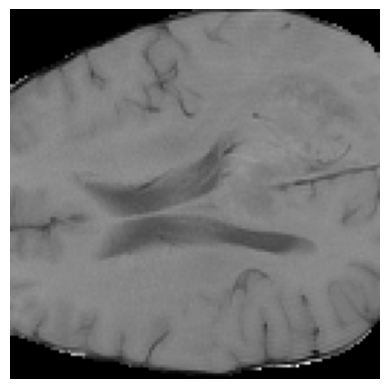

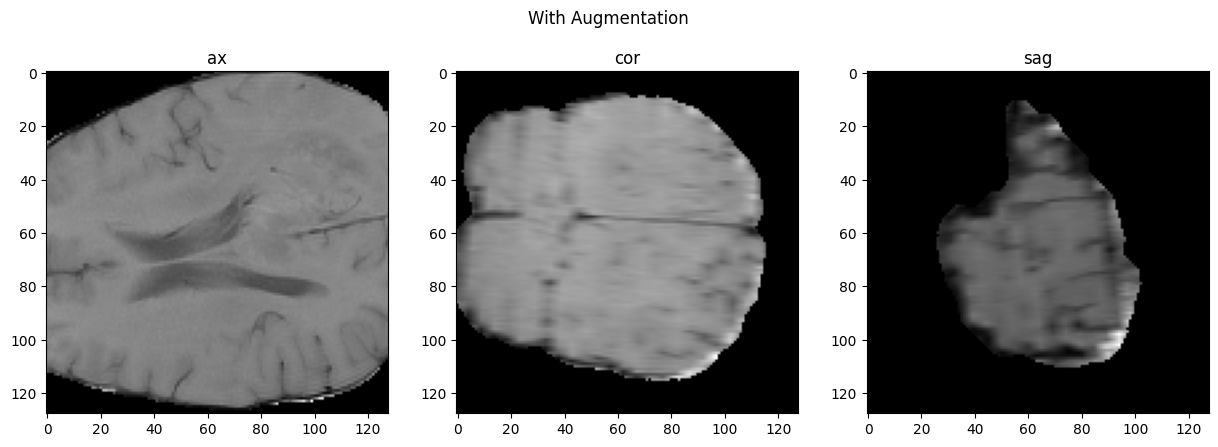

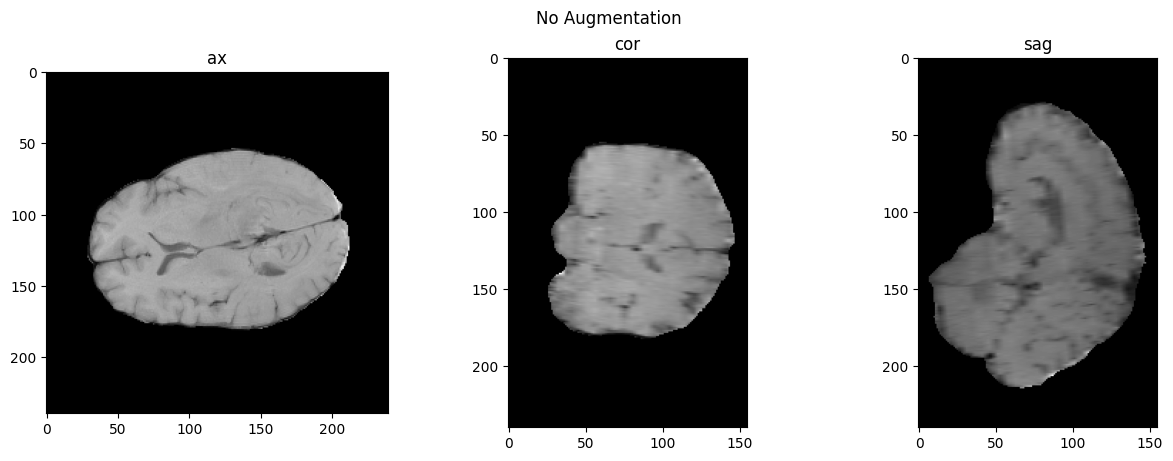

Total folders:  1251
Working with subject: /content/sample_data/GLI_data/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01264-000
transformed shapes squeezed torch.Size([240, 240, 156]), mask shape torch.Size([240, 240, 155]), before was torch.Size([1, 240, 240, 155])


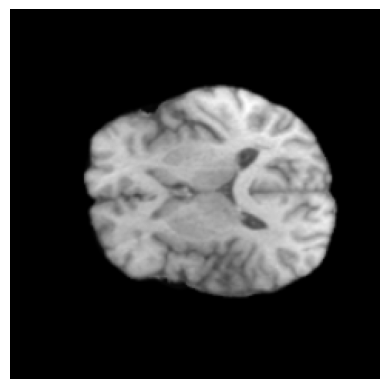

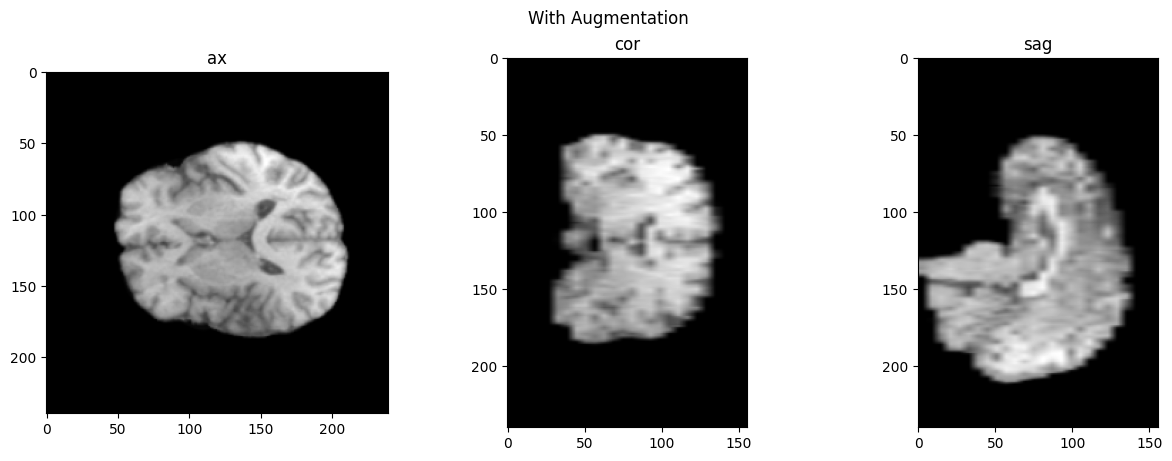

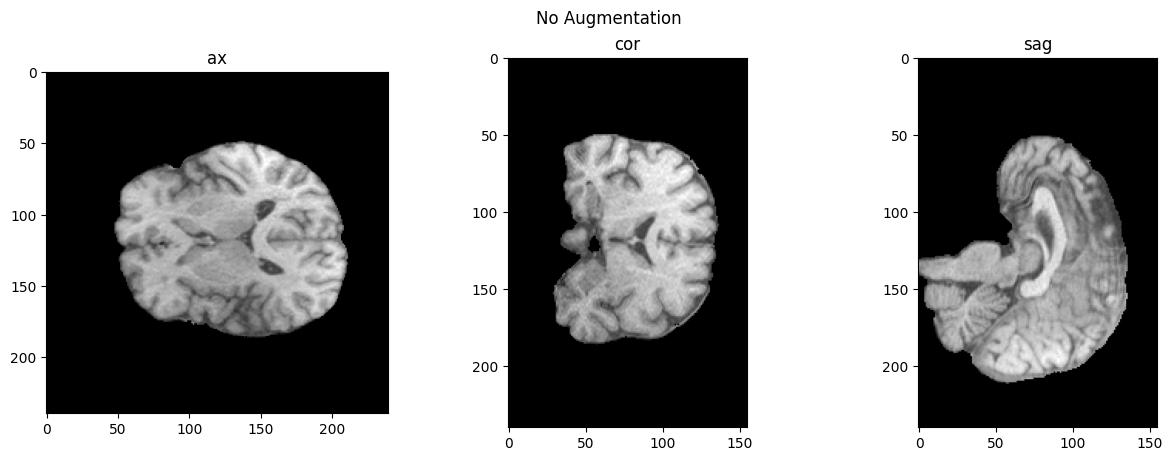

In [68]:
# choose augmentation
#1: flipR
#2: resampleR
#3: anisoR
#4: blurR
#5: noiseR
#6: motionR
#7: biasfR
#8: ghostR
# 9: patch
# 10: train
# 11: fakeSSA_resamp
# 12: fakeSSA_augs
###############################################
# print_files (dir, Aug_index, Patient_index)
# NB !! Rememebr to change the Aug_index depending on the Aug you choose.
plot_augs(data_dir,10)
plot_augs(data_dir,11)
